# **Assignment  02** 

Name: 
### **2**

PRN: 
### **240340128007**

### **Implement Perceptron with Sigmoid activation Function**

In [79]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

## Import Statements

In [80]:
###-----------------
### Import Libraries
###-----------------

import os
import sys
sys.path.insert(0, r'G:\My Drive\DNN')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
 
# from utils.helper import fn_plot_decision_boundary # this function is from helper.py

In [81]:
# print (fn_plot_decision_boundary.__doc__)

## Setup Global Parameters

In [82]:
###----------------
### Some parameters
###----------------

RANDOM_STATE = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE)
rng = np.random.default_rng(seed = RANDOM_STATE) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 10000  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000
TEST_SIZE = 0.2

# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

## Generate Data Set
<div style="font-family: Arial; font-size:1.2em;">
Sklearn's dataset generator is good source of data for learning. To keep the example simple, I'll suggest  <a href="http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html">make_moon</a> dataset generator.
</div>

In [83]:
X, y = datasets.make_moons(n_samples=N_SAMPLES, 
                           shuffle=True, 
                           noise=NOISE, 
                           random_state=RANDOM_STATE)
X[:5], y[:5]

(array([[ 0.90633951,  0.90267624],
        [-1.11536828,  0.75579289],
        [ 1.88769158,  0.4175967 ],
        [-0.93345034, -0.02299851],
        [-0.96872877,  0.06396285]]),
 array([0, 0, 1, 0, 0], dtype=int64))

## Visualization
<p style="font-family: Arial; font-size:1.2em">
DataFrames are easier to visualize
</p>

In [84]:
data_df = pd.DataFrame(X, columns = ['A', 'B'])

data_df['target'] = y

data_df.head()

,A,B,target
0,0.906340,0.902676,0
1,-1.115368,0.755793,0
2,1.887692,0.417597,1
3,-0.933450,-0.022999,0
4,-0.968729,0.063963,0


In [85]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       1000 non-null   float64
 1   B       1000 non-null   float64
 2   target  1000 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 23.6 KB


In [86]:
data_df.describe() # Generate descriptive statistic

,A,B,target
count,1000.000000,1000.000000,1000.00000
mean,0.490841,0.239025,0.50000
std,0.898951,0.540082,0.50025
min,-1.688795,-0.955280,0.00000
25%,-0.149565,-0.205090,0.00000
50%,0.500100,0.241163,0.50000
75%,1.095048,0.680394,1.00000
max,2.419113,1.612075,1.00000


In [87]:
# what labels are present?
data_df.target.unique()

array([0, 1], dtype=int64)

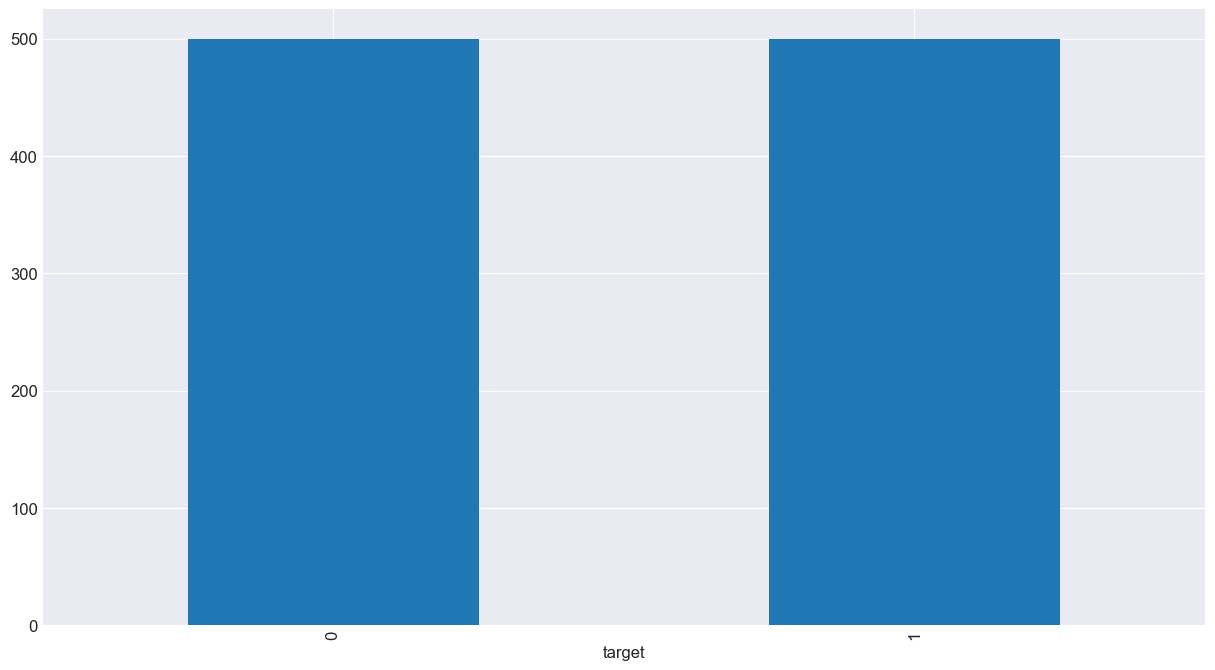

In [88]:
fig, ax = plt.subplots() # Instantiate
    
data_df['target'].value_counts().plot(ax=ax, kind='bar');

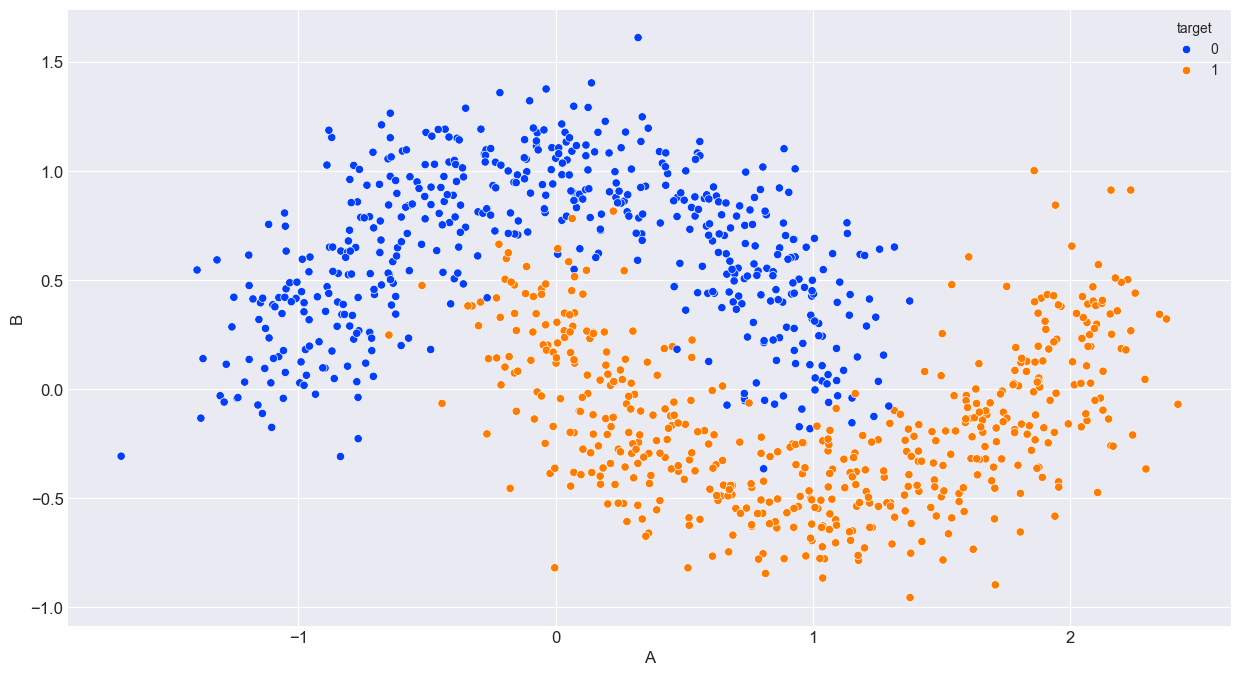

In [89]:
# Using Seaborn
ax = sns.scatterplot(data=data_df, # data from dataframe
                     x='A', y='B',  # X axis and y axis columns
                     palette=sns.color_palette("bright", 2), # color map
                     hue='target'); # Color as per target column

In [90]:
# data_train, data_test = data_df.to_numpy()[:900], data_df.to_numpy()[900:]

In [91]:
# data_train.shape, data_test.shape

In [92]:
# rng.random(data_train.shape[1])

Stochastic Gradient Descent

In [93]:
def fn_sigmoid(z):
    return 1 / (1 + (np.exp(-z)))

In [94]:
t = fn_sigmoid(np.asarray([[-1, 0, 1], [-np.inf, 0, np.inf]]))
t

array([[0.26894142, 0.5       , 0.73105858],
       [0.        , 0.5       , 1.        ]])

In [95]:
def fn_activ(x):

    return np.tanh(x)

def fn_activ_prime(x):

    return 1.0 - np.tanh(x)**2

In [96]:
def predict(model, X_p):

    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    ### Forward Propagation

    # Layer 1
    z1 = X_p.dot(W1) + b1 # Aggregation
    a1 = fn_activ(z1) # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2 # Aggregation
    a2 = fn_sigmoid(z2) # Activation
    
    return a2 >= 0.5 # It is greater equal to 0.5 

In [97]:
def calculate_loss(model, X_l, y_l):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    m = X_l.shape[0]

    # Layer 1
    z1 = X_l.dot(W1) + b1 # Aggregation
    a1 = fn_activ(z1) # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2 # Aggregation
    a2 = fn_sigmoid(z2) # Activation
    
    data_loss = -(y_l*np.log(a2)).sum() # Binary

    return data_loss/m 

In [98]:
loss_hist = {}

In [99]:
def build_model(X_tr, y_tr, nn_hdim, nn_out, alpha=ALPHA ,epochs = EPOCHS):
    '''
    Args:
        X_tr : Training features
        y_tr : Training labels
        nn_hdim : Number of nodes in the hidden layer
        nn_out : Size of output
    '''
    m, nn_input_dim = X_tr.shape
    nn_output_dim = nn_out
    
    W1 = rng.random((nn_input_dim, nn_hdim), 
             dtype = np.float32) / np.sqrt(nn_input_dim)

    W2 = rng.random((nn_hdim, nn_output_dim), 
            dtype = np.float32) / np.sqrt(nn_hdim)
    # W1 = np.random.rand(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    # W2 = np.random.rand(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)

    b1 = np.zeros((1, nn_hdim), dtype= np.float32)

    b2 = np.zeros((1, nn_output_dim), dtype= np.float32)

    curr_loss = 0
    loss, epoch = [], []

    for i in range(0, epochs):
        ### Forward Propagation

        # Layer 1
        z1 = X_tr.dot(W1) + b1
        a1 = fn_activ(z1)

        # Layer 2
        z2 = a1.dot(W2) + b2
        a2 = fn_sigmoid(z2)
    
        # Back Propagation 
        assert (a2.shape == y_tr.shape), f'check y {a2.shape}/{y_tr.shape}'
        dz2 = a2 - y_tr ## REMEMBER dim of a2 and y to be same

        dW2 = (a1.T).dot(dz2)
        assert(W2.shape == dW2.shape), f'check W2 {W2.shape}/{dW2.shape}'

        db2 = np.sum(dz2, axis= 0 , keepdims = True)
        assert(b2.shape == db2.shape), f'check b2 {b2.shape}/{db2.shape}'

        da1 = dz2.dot(W2.T)
        assert(a1.shape == da1.shape), f'check a1 {a1.shape}/{da1.shape}'

        # Layer1
        dz1 = da1 * fn_activ_prime(z1)
        assert(z1.shape == dz1.shape), f'check z1 {z1.shape}/{dz1.shape}'
    
        dW1 = (X_tr.T).dot(dz1)
        assert(W1.shape == dW1.shape), f'check W1 {W1.shape}/{dW1.shape}'

        db1 = np.sum(dz1, axis= 0 , keepdims = True)
        assert(b1.shape == db1.shape), f'check b1 {b1.shape}/{db1.shape}'


        # Gradient Update
        W1 += -alpha * dW1/m
        b1 += -alpha * db1/m
        W2 += -alpha * dW2/m
        b2 += -alpha * db2/m

        model = {'W1': W1, 'b1' : b1,
                 'W2': W2, 'b2' : b2
                 }
    
        curr_loss = calculate_loss(model, X_tr, y_tr)
        loss.append(curr_loss)
        epoch.append(i)
        if i%100 == 0:
            print(f'After epoch: {i:3d}; loss: {curr_loss: .5f}')

    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss

    return model

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TEST_SIZE,
                                                    stratify=y,
                                                    random_state=RANDOM_STATE)

In [101]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((800, 2), (200, 2), (800,), (200,))

In [102]:
print(y_train.shape)
y_train = y_train.reshape(-1, 1)
y_train.shape

(800,)


(800, 1)

In [103]:
nn_out_dim = 1

model = build_model(X_train, y_train, 4, nn_out_dim)

After epoch:   0; loss:  0.29173
After epoch: 100; loss:  0.22858
After epoch: 200; loss:  0.17566
After epoch: 300; loss:  0.15706
After epoch: 400; loss:  0.15183
After epoch: 500; loss:  0.15021
After epoch: 600; loss:  0.14953
After epoch: 700; loss:  0.14912
After epoch: 800; loss:  0.14880
After epoch: 900; loss:  0.14849
After epoch: 1000; loss:  0.14811
After epoch: 1100; loss:  0.14760
After epoch: 1200; loss:  0.14679
After epoch: 1300; loss:  0.14546
After epoch: 1400; loss:  0.14331
After epoch: 1500; loss:  0.14007
After epoch: 1600; loss:  0.13569
After epoch: 1700; loss:  0.13044
After epoch: 1800; loss:  0.12475
After epoch: 1900; loss:  0.11903
After epoch: 2000; loss:  0.11359
After epoch: 2100; loss:  0.10855
After epoch: 2200; loss:  0.10397
After epoch: 2300; loss:  0.09984
After epoch: 2400; loss:  0.09611
After epoch: 2500; loss:  0.09273
After epoch: 2600; loss:  0.08968
After epoch: 2700; loss:  0.08689
After epoch: 2800; loss:  0.08433
After epoch: 2900; loss:

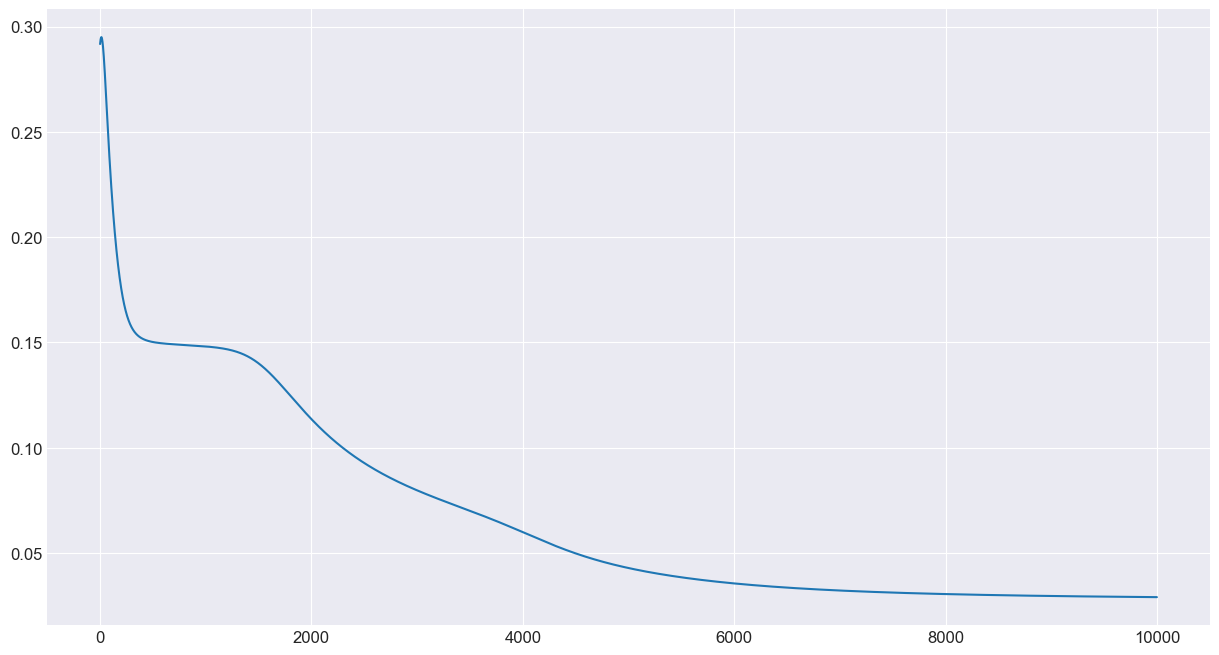

In [104]:
plt.plot(loss_hist['epoch'], loss_hist['loss'])

In [105]:
model

{'W1': array([[ 3.6360202 ,  2.0720682 ,  2.7123914 ,  2.3783336 ],
        [ 3.0908098 , -0.92780393, -1.3015468 , -0.9970487 ]],
       dtype=float32),
 'b1': array([[-2.3417275,  1.247887 , -3.491836 ,  1.3485874]], dtype=float32),
 'W2': array([[-6.4237223],
        [ 3.2974377],
        [ 6.3521724],
        [ 3.865634 ]], dtype=float32),
 'b2': array([[-0.48924544]], dtype=float32)}

In [106]:
y_pred = predict(model, X_test)
accuracy_score(y_test, y_pred)


0.965

In [107]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[98,  2],
       [ 5, 95]], dtype=int64)

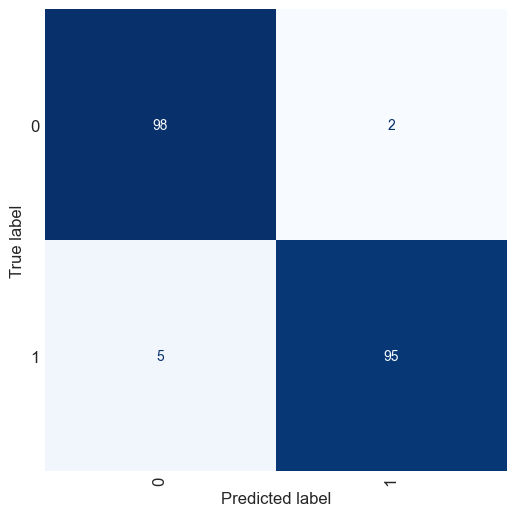

In [108]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
fig, ax = plt.subplots(figsize = (6,6))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
# Disable the grid
ax.grid(False)

plt.show();

NameError: name 'errors' is not defined

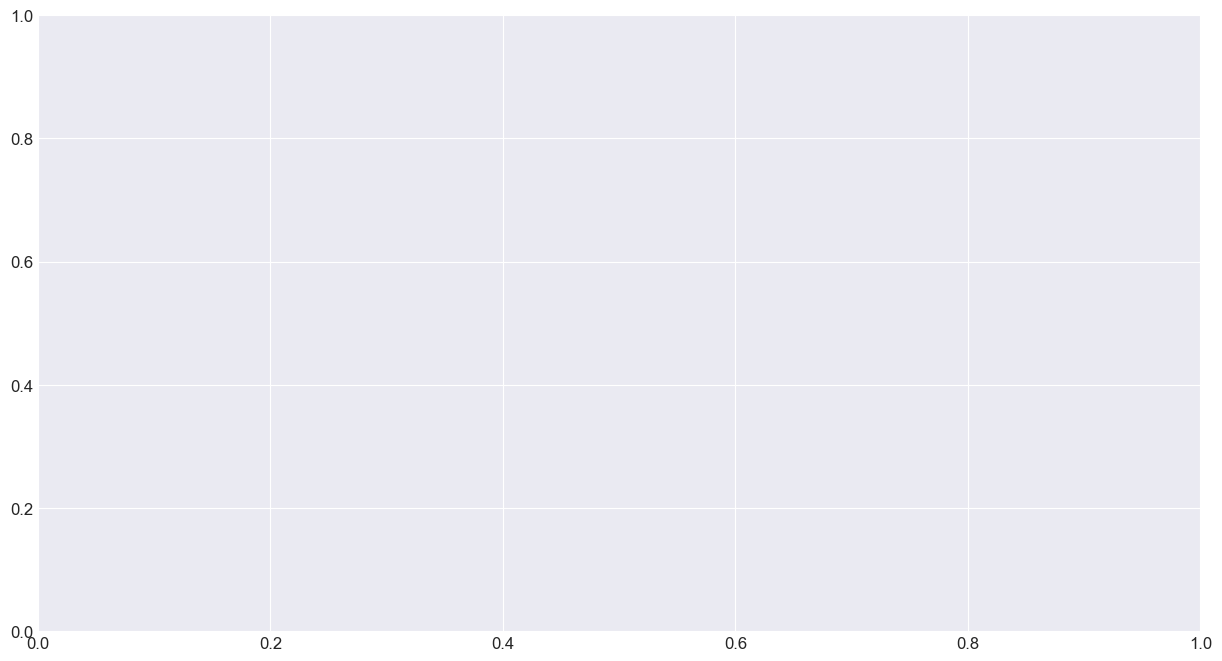

In [109]:
fig, ax = plt.subplots()
ax.plot(errors);

# little beautification
txtstr = "Training Error: \n  Start : {:7.2f}\n   End : {:7.2f}".format(errors[0],errors[-1]) #text to plot

# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper right in axes coords
ax.text(0.75, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

ax.set_xlabel("Epochs")

ax.set_ylabel("Error")

ax.grid();

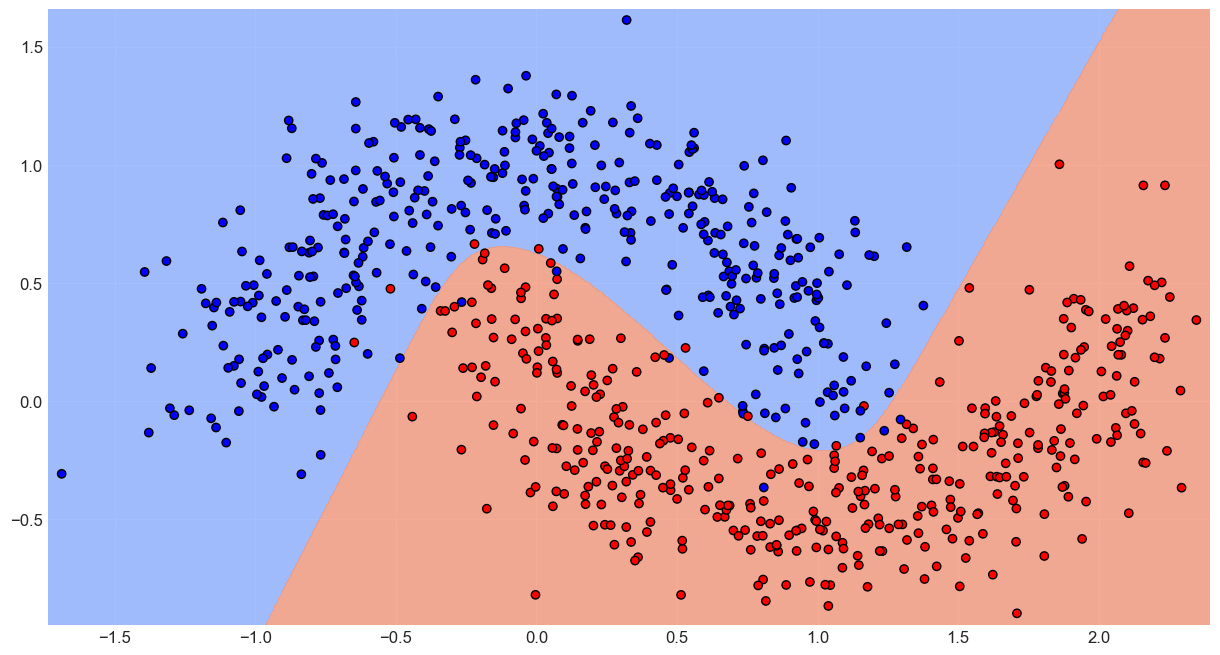

In [113]:
X = X_train

fig, ax = plt.subplots()
dm = 0.005 # Smoothen the curve

X_min, X_max = X[:,0].min() - 0.05, X[:,0].max() + 0.05
y_min, y_max = X[:,1].min() - 0.05, X[:,1].max() + 0.05

xx, yy = np.meshgrid(np.arange(X_min, X_max, dm),
                     np.arange(y_min, y_max, dm))

XX = np.c_[xx.ravel(), yy.ravel()]
# XX = np.hstack((XX, np.ones((XX.shape[0],1))))

y_pred = predict(model, XX)

# for row in XX:
#     pred = predict(row, model)
#     y_pred.append(np.round(pred)) # to get only 2 sections in the contour, we used np.round(pred)

Z = np.array(y_pred).reshape(xx.shape)

ax.contourf(xx, yy, Z, cmap=CMAP, alpha=0.8)
ax.scatter(X[:,0], X[:,1], c = y_train,edgecolors='k', cmap=plt.cm.bwr, marker='o');

In [ ]:
xx.shape, yy.shape

NameError: name 'xx' is not defined

Training Accuracy

In [ ]:
predictions = []

for row in data_train:
    
    a = predict(row, weights)
    
    prediction = 0
    
    if a >= 0.5: prediction = 1 # argmax

    predictions.append(prediction)

NameError: name 'data_train' is not defined

In [ ]:
accuracy_score(data_train[:,-1], predictions)

NameError: name 'data_train' is not defined

Testing Accuracy

In [ ]:
predictions = []

for row in data_test:
    
    a = predict(row, weights)
    
    prediction = 0
    
    if a >= 0.5: prediction = 1
    predictions.append(prediction)

accuracy_score(data_test[:,-1], predictions)


NameError: name 'data_test' is not defined

In [ ]:
cm = confusion_matrix(data_test[:, -1], predictions)
cm

NameError: name 'data_test' is not defined

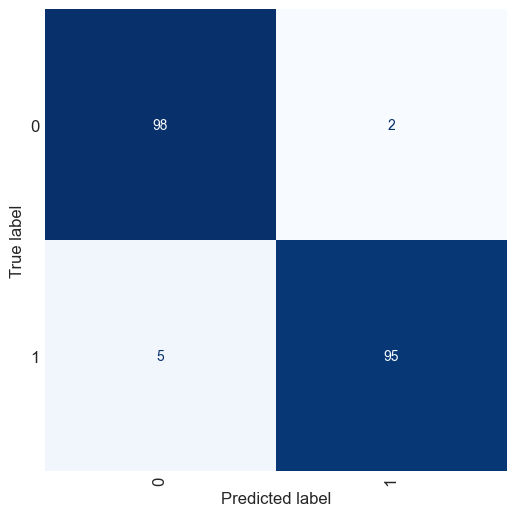

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    
fig, ax = plt.subplots(figsize = (6,6))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)
# Disable the grid
ax.grid(False)

plt.show();